In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

!ls

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark



In [4]:
spark = SparkSession.builder.appName("TemperatureAnalysis").getOrCreate()

df = spark.read.csv("Global_Temperatures_by_Country.csv", header=True, inferSchema=True)
df.head()

Row(dt='1819-05-01', AverageTemperature=None, AverageTemperatureUncertainty=None, Country='Asia')

In [ ]:
df.show()

In [6]:
df_clean = df.filter(df.AverageTemperature.isNotNull())
df_clean.show()

+----------+------------------+-----------------------------+-------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|Country|
+----------+------------------+-----------------------------+-------+
|1836-08-01|            24.997|                          2.0|  Burma|
|1828-10-01|            23.275|                          2.0|  Egypt|
|1834-05-01|            27.213|                          2.0|  Egypt|
|1842-03-01|             7.851|                          2.0|  Italy|
|1854-07-01|            30.018|                          2.0|  Libya|
|1832-08-01|            25.471|                          2.0|  Malta|
|1753-05-01|            19.472|                          2.0|  Malta|
|1891-05-01|30.718000000000004|                          2.0|  Qatar|
|1870-05-01|            23.256|                          2.0|  Syria|
|1857-02-01| 6.303999999999999|                          2.0|  Syria|
|1880-09-01|            28.949|                          2.0|  Yemen|
|1830-09-01|14.71599

In [7]:
avg_temp_per_year = df_clean.groupBy("Country").agg(avg("AverageTemperature"))
avg_temp_per_year.show()

+-------------+-----------------------+
|      Country|avg(AverageTemperature)|
+-------------+-----------------------+
|         Chad|     27.120466282420747|
|     Paraguay|     23.237967557251896|
|       Russia|    -5.5218819126819145|
|     Anguilla|      26.61049185043148|
| Kingman Reef|       27.1330344387755|
|        Yemen|      26.25359672528805|
|Palmyra Atoll|     27.163455994897976|
|      Senegal|     27.967375000000008|
|       Sweden|     2.3863319646241354|
|     Kiribati|     26.736865347798325|
|       Guyana|     25.930920115495663|
|        Burma|     23.706197239536962|
|       Jersey|     10.928408717624762|
|      Eritrea|      26.80265311004784|
|  Philippines|     26.440472486772496|
|        Tonga|      23.23624785276073|
|     Djibouti|     28.816602533172478|
|     Malaysia|      25.80544200779725|
|    Singapore|     26.523102826510737|
|         Fiji|     25.038671779141108|
+-------------+-----------------------+
only showing top 20 rows



In [8]:
from pyspark.sql.functions import col, substring
df_with_year = df_clean.withColumn('Year', substring('dt', 1, 4))
df_with_year.show()

+----------+------------------+-----------------------------+-------+----+
|        dt|AverageTemperature|AverageTemperatureUncertainty|Country|Year|
+----------+------------------+-----------------------------+-------+----+
|1836-08-01|            24.997|                          2.0|  Burma|1836|
|1828-10-01|            23.275|                          2.0|  Egypt|1828|
|1834-05-01|            27.213|                          2.0|  Egypt|1834|
|1842-03-01|             7.851|                          2.0|  Italy|1842|
|1854-07-01|            30.018|                          2.0|  Libya|1854|
|1832-08-01|            25.471|                          2.0|  Malta|1832|
|1753-05-01|            19.472|                          2.0|  Malta|1753|
|1891-05-01|30.718000000000004|                          2.0|  Qatar|1891|
|1870-05-01|            23.256|                          2.0|  Syria|1870|
|1857-02-01| 6.303999999999999|                          2.0|  Syria|1857|
|1880-09-01|            2

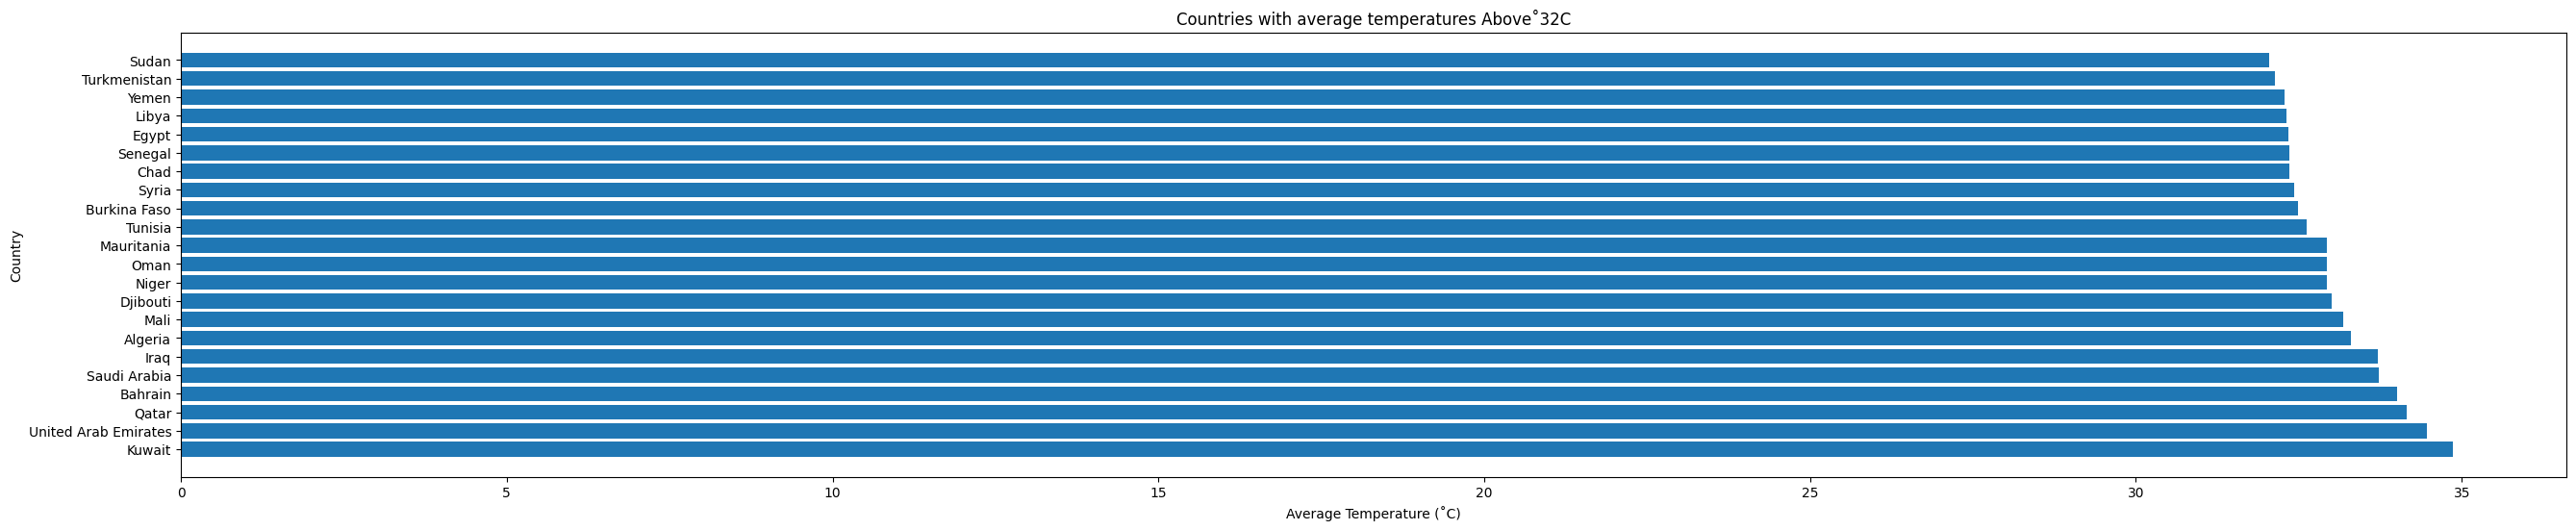

In [9]:
import matplotlib.pyplot as plt
high_temp_df = df_with_year.filter(df_with_year['AverageTemperature'] > 32)

avg_temp_high_countries = high_temp_df.groupBy('Country').agg(avg('AverageTemperature').alias('AvgTemp'))

pdf = avg_temp_high_countries.toPandas()

pdf = pdf.sort_values(by='AvgTemp', ascending=False)

plt.figure(figsize=(32,6))
plt.barh(pdf['Country'], pdf['AvgTemp'])
plt.title('Countries with average temperatures Above˚32C')
plt.xlabel('Average Temperature (˚C)')
plt.ylabel('Country')
plt.show()

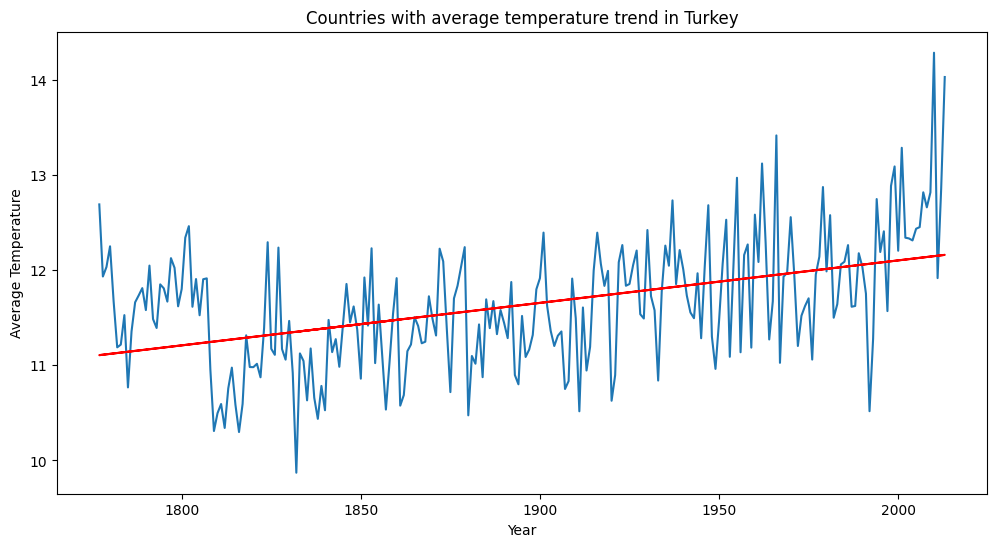

In [12]:
import numpy as np
pdf = df_with_year.filter(df_with_year.Country == 'Turkey').toPandas()

pdf['Year'] = pdf['Year'].astype(int)

x = np.array(pdf['Year'])
y = np.array(pdf['AverageTemperature'])

pdf = pdf.groupby('Year')['AverageTemperature'].mean().reset_index()
# Calculate the trend line (using linear regression)
coefficients = np.polyfit(x,y, 1)
trend_line = np.poly1d(coefficients)

plt.figure(figsize=(12,6))
plt.plot(pdf['Year'], pdf['AverageTemperature'])
plt.plot(x, trend_line(x), color='red', label='Trend Line')
plt.title('Countries with average temperature trend in Turkey')
plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.show()

In [ ]:
import random

last_year = df_with_year.agg({'Year': 'max'}).collect()[0][0]

last_year_df = df_with_year.filter(df_with_year['Year'] == last_year)

avg_temp_last_year = last_year_df.groupBy('Country').agg(avg('AverageTemperature').alias('AvgTemp'))

pdf = avg_temp_last_year.toPandas()

random_countries = random.sample(pdf['Country'].tolist(), 15)
pdf_filtered = pdf[pdf['Country'].isin(random_countries)]

pdf_filtered = pdf_filtered.sort_values(by='AvgTemp', ascending=True)

plt.figure(figsize=(12,6))
plt.barh(pdf_filtered['Country'], pdf_filtered['AvgTemp'])
plt.title(f'Average Temperature in Random 15 Countries for the year {last_year}')
plt.xlabel('Average Temperature (˚C)')
plt.ylabel('Country')
plt.show()